# Submitting batch prediction jobs to Cloud AI Platform Prediction

In [ ]:
!gsutil ls gs://workshop-datasets/cifar10

In [1]:
import absl
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

import IPython.display as display

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

print(tf.__version__)
print(tf.executing_eagerly())

2.1.0
True


## Explore data

In [2]:
label_names = [
'airplane',
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck',
]

In [3]:
def parse_example(example_proto):
    image_features = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    parsed_image = tf.io.parse_example(example_proto, image_features)
    image = parsed_image['image_raw']
    label = parsed_image['label']

    return image, label

train_files = ['gs://workshop-datasets/cifar10/train.tfrecord']
dataset = tf.data.TFRecordDataset(train_files)

images = []
labels = []
for example in dataset.take(32):
    image, label = parse_example(example)
    image = tf.io.decode_image(image).numpy()
    label = label.numpy()
    images.append(image)
    labels.append(label)

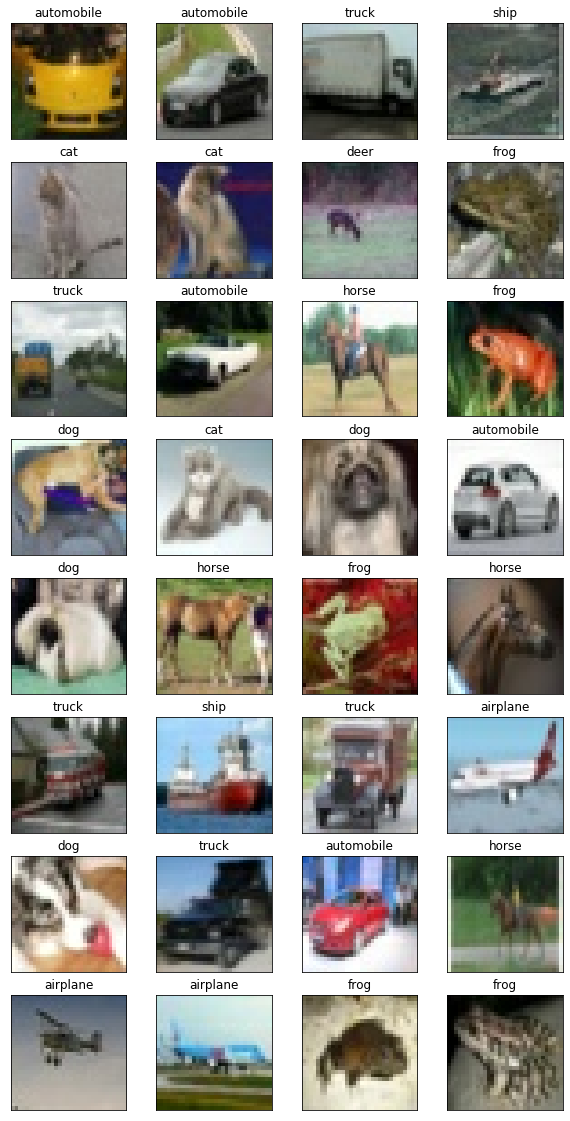

In [4]:
figsize=(10, 20)
fig, axis = plt.subplots(8, 4, figsize=figsize)


for ax, image, label in zip(axis.flat[0:], images, labels):
    ax.set_title(label_names[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(image)

## Training

In [5]:
def create_model():
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))
    d1 = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu')(inputs)
    d2 = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu')(d1)
    d3 = tf.keras.layers.Flatten()(d2)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(d3)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9),
        loss='categorical_crossentropy',
        metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])
    
    return model

In [6]:
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        18464     
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                250890    
Total params: 271,146
Trainable params: 271,146
Non-trainable params: 0
_________________________________________________________________


In [7]:
def prepare_dataset(dataset_files):

    
    def _parse_image(example_proto):
        image_features = {
            'image_raw': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.int64)
        }

        parsed_image = tf.io.parse_single_example(example_proto, image_features)
        image_str = parsed_image['image_raw']
        label = parsed_image['label']
        
        image = tf.image.decode_image(image_str, channels=3)
        image = tf.reshape(image, (32, 32, 3))
        image = tf.cast(image, tf.float32) / 255
        
        label = tf.one_hot(label, 10)
        return image, label
    
    dataset = tf.data.TFRecordDataset(train_files)
    dataset = dataset.map(_parse_image).batch(32, drop_remainder=True)
    
    return dataset

In [8]:
train_files = ['gs://workshop-datasets/cifar10/train.tfrecord']
train_dataset = prepare_dataset(train_files)

validation_files = ['gs://workshop-datasets/cifar10/test.tfrecord']
validation_dataset = prepare_dataset(validation_files)

In [9]:
model.fit(train_dataset,
         epochs=200,
         validation_data=validation_dataset,
         validation_freq=1)

Epoch 1/200
1562/1562 [==============================] - 27s 17ms/step - loss: 2.1194 - accuracy: 0.2288 - val_loss: 1.9348 - val_accuracy: 0.3269
Epoch 2/200
1562/1562 [==============================] - 24s 15ms/step - loss: 1.8917 - accuracy: 0.3374 - val_loss: 1.8459 - val_accuracy: 0.3579
Epoch 3/200
1562/1562 [==============================] - 24s 15ms/step - loss: 1.8295 - accuracy: 0.3638 - val_loss: 1.7950 - val_accuracy: 0.3759
Epoch 4/200
1562/1562 [==============================] - 24s 15ms/step - loss: 1.7778 - accuracy: 0.3825 - val_loss: 1.7418 - val_accuracy: 0.3960
Epoch 5/200
1562/1562 [==============================] - 23s 15ms/step - loss: 1.7234 - accuracy: 0.4017 - val_loss: 1.6901 - val_accuracy: 0.4122
Epoch 6/200
1562/1562 [==============================] - 23s 15ms/step - loss: 1.6747 - accuracy: 0.4173 - val_loss: 1.6454 - val_accuracy: 0.4265
Epoch 7/200
1562/1562 [==============================] - 25s 16ms/step - loss: 1.6302 - accuracy: 0.4317 - val_loss: 1

In [10]:
file_path = '/home/jupyter/save_model'

tf.keras.models.save_model(model, file_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/jupyter/save_model/assets


In [11]:
!saved_model_cli show --dir /home/jupyter/save_model --all

2020-03-16 02:05:59.370568: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-03-16 02:06:00.465479: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2020-03-16 02:06:00.467183: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT


## Inference

In [63]:
def parse_images(example_protos):
    image_features = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    parsed_images = tf.io.parse_example(example_protos, image_features)
    image_strs = parsed_images['image_raw']
    images = tf.map_fn(tf.image.decode_image, image_strs, dtype=tf.uint8)
    #images = tf.cast(images, tf.float32) / 255
    #image = tf.reshape(image, (32, 32, 3))
    
    labels = parsed_images['label']

    return images, labels
    

In [71]:
test_files = ['gs://workshop-datasets/cifar10/test.tfrecord']
dataset = tf.data.TFRecordDataset(test_files).batch(32)

examples = dataset.take(1)
examples = list(examples)[0]
examples.shape

TensorShape([32])

In [72]:
images, labels = parse_images(examples)

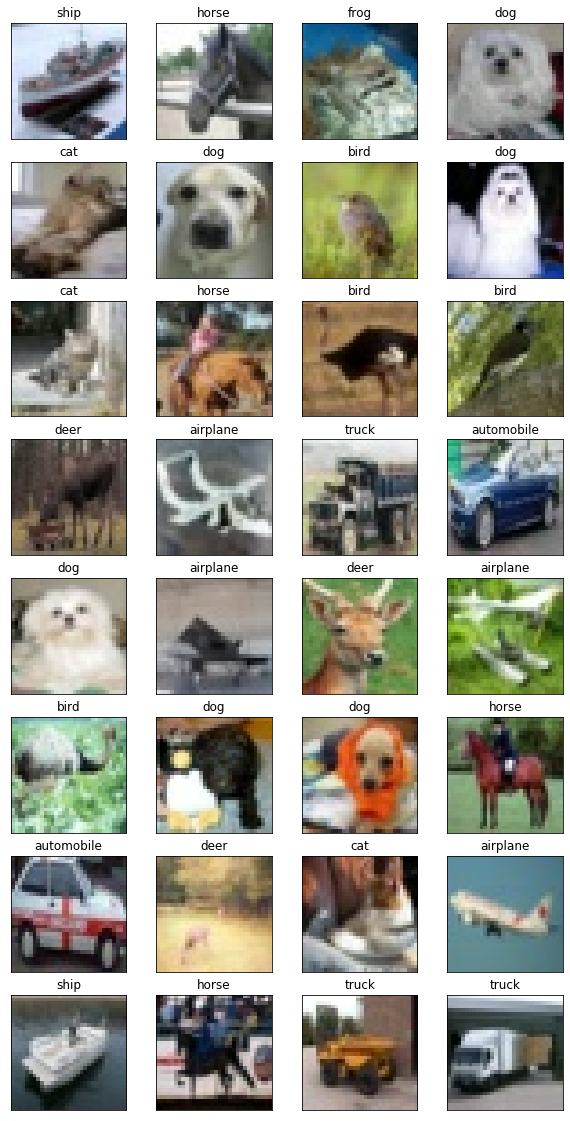

In [76]:
figsize=(10, 20)
fig, axis = plt.subplots(8, 4, figsize=figsize)

for ax, image, label in zip(axis.flat[0:], images, labels):
    ax.set_title(label_names[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(image)

In [17]:
def preprocess_images(example_protos):
    image_features = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    parsed_images = tf.io.parse_example(example_protos, image_features)
    image_strs = parsed_images['image_raw']
    images = tf.map_fn(tf.image.decode_image, image_strs, dtype=tf.uint8)
    images = tf.cast(images, tf.float32) / 255

    return images
    

In [78]:
preprocessed_images = preprocess_images(examples)

In [79]:
file_path = '/home/jupyter/save_model'

model = tf.keras.models.load_model(file_path)

In [80]:
predictions = model.predict(preprocessed_images)

In [81]:
predicted_labels = np.argmax(predictions, axis=1)

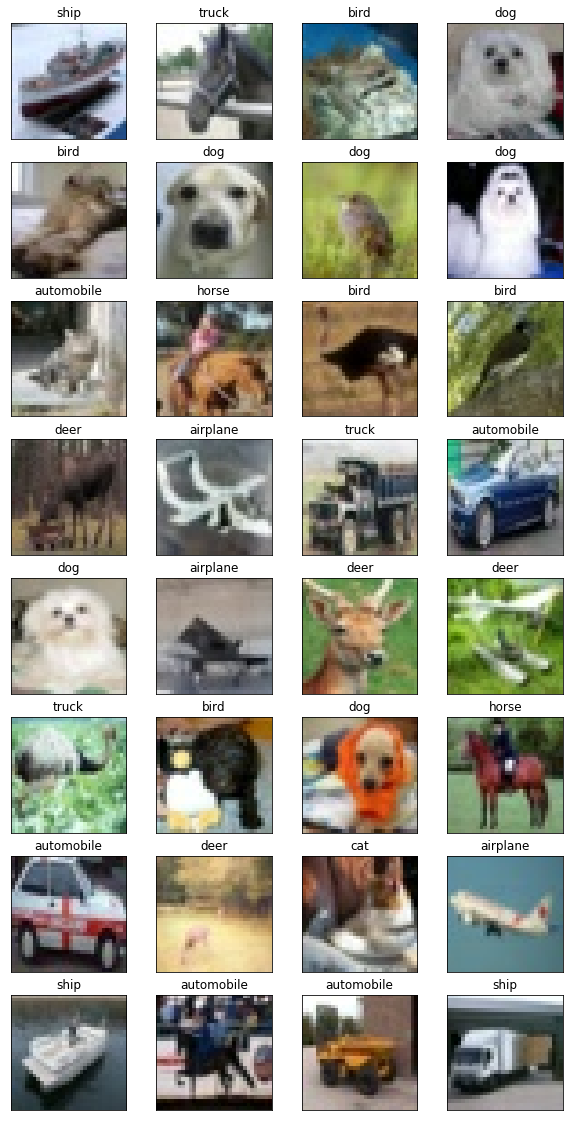

In [82]:
figsize=(10, 20)
fig, axis = plt.subplots(8, 4, figsize=figsize)

for ax, image, label in zip(axis.flat[0:], images, predicted_labels):
    ax.set_title(label_names[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(image)

## Create serving model

In [150]:
test_files = ['gs://workshop-datasets/cifar10/test.tfrecord']
dataset = tf.data.TFRecordDataset(test_files).batch(3)

examples = dataset.take(1)
examples = list(examples)[0]
examples.shape

TensorShape([3])

In [86]:
def preprocess_images(example_protos):
    image_features = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    parsed_images = tf.io.parse_example(example_protos, image_features)
    image_strs = parsed_images['image_raw']
    images = tf.map_fn(tf.image.decode_image, image_strs, dtype=tf.uint8)
    images = tf.cast(images, tf.float32) / 255

    return images

In [194]:
def preprocess_images(example_protos):
    image_features = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    parsed_images = tf.io.parse_example(example_protos, image_features)
    image_strs = parsed_images['image_raw']
    images = tf.expand_dims(tf.image.decode_image(image_strs[0], channels=3), 0)
    for image_str in image_strs[1:]:
        image = tf.image.decode_image(image_str, channels=3)
        images = tf.concat([images, tf.expand_dims(image, 0)], axis=0)
        
    
    #images = tf.map_fn(tf.image.decode_image, image_strs, dtype=tf.uint8)
    #images = tf.cast(images, tf.float32) / 255
    #images = image_strs

    return images

In [195]:
preprocess_images(examples)

<tf.Tensor: shape=(3, 32, 32, 3), dtype=uint8, numpy=
array([[[[133, 143, 155],
         [140, 150, 162],
         [152, 164, 180],
         ...,
         [231, 249, 255],
         [238, 246, 255],
         [242, 248, 255]],

        [[200, 209, 226],
         [200, 212, 228],
         [205, 217, 233],
         ...,
         [224, 242, 255],
         [228, 240, 255],
         [229, 236, 254]],

        [[220, 231, 253],
         [218, 231, 250],
         [218, 231, 250],
         ...,
         [214, 233, 247],
         [223, 235, 247],
         [226, 236, 246]],

        ...,

        [[213, 225, 247],
         [198, 210, 232],
         [190, 203, 222],
         ...,
         [ 42,  78, 128],
         [ 34,  77, 130],
         [ 31,  78, 134]],

        [[209, 216, 244],
         [188, 198, 225],
         [178, 188, 213],
         ...,
         [ 32,  73, 129],
         [ 31,  73, 131],
         [ 31,  76, 135]],

        [[205, 210, 240],
         [187, 194, 223],
         [179, 189, 

In [196]:
@tf.function
def cifar_predict(example_protos):
    images = preprocess_images(example_protos)
    predictions = images
    return predictions

In [197]:
cifar_predict_examples = cifar_predict.get_concrete_function(
    example_protos = tf.TensorSpec([None], dtype=tf.string)
)

In [198]:
cifar_predict_examples(examples)

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  2 root error(s) found.
  (0) Invalid argument: During Variant Host->Device Copy: non-DMA-copy attempted of tensor type: string
  (1) Invalid argument: During Variant Host->Device Copy: non-DMA-copy attempted of tensor type: string
0 successful operations.
0 derived errors ignored.
	 [[{{node TensorArrayUnstack/TensorListFromTensor/_102}}]]
	 [[Func/decode_image/cond_jpeg/else/_1/cond_png/then/_78/input/_97/_56]]
  (1) Invalid argument:  2 root error(s) found.
  (0) Invalid argument: During Variant Host->Device Copy: non-DMA-copy attempted of tensor type: string
  (1) Invalid argument: During Variant Host->Device Copy: non-DMA-copy attempted of tensor type: string
0 successful operations.
0 derived errors ignored.
	 [[{{node TensorArrayUnstack/TensorListFromTensor/_102}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_cifar_predict_1893828]

Function call stack:
cifar_predict -> cifar_predict


In [116]:
@tf.function
def power(a,b):
  print('Tracing "power"\n')
  return a**b

In [117]:
float_power = power.get_concrete_function(
  a = tf.TensorSpec(shape=[None], dtype=tf.float32),
  b = tf.TensorSpec(shape=[None], dtype=tf.float32))

Tracing "power"



In [122]:
result = float_power([3.0, 2.0], [3.0, 2.0])

ValueError: All inputs to `ConcreteFunction`s must be Tensors; on invocation of power, the 0-th input ([3.0, 2.0]) was not a Tensor.

In [121]:
type(result)

tensorflow.python.framework.ops.EagerTensor

## Batch predict with AI Platform

In [ ]:
DATA_FORMAT='tf-record'
INPUT_PATHS='gs://workshop-datasets/cifar10/test.tfrecord'
OUTPUT_PATH='gs://mlops-dev-100-artifact-store/output/'
MODEL_URI='gs://mlops-dev-100-artifact-store/cifar/save_model'
VERSION_NAME='v1'
REGION='us-central1'
RUNTIME_VERSION=2.1
now=!(date +"%Y%m%d_%H%M%S")
JOB_NAME="cifar10_classifier_" + now[0]
MAX_WORKER_COUNT=2

In [ ]:
!gsutil cp -r /home/jupyter/save_model $MODEL_URI

In [ ]:
!gsutil ls $MODEL_URI

In [ ]:
DATA_FORMAT

In [ ]:
!gcloud ai-platform jobs submit prediction $JOB_NAME \
    --model-dir $MODEL_URI \
    --runtime-version $RUNTIME_VERSION \
    --input-paths $INPUT_PATHS \
    --output-path $OUTPUT_PATH \
    --region $REGION \
    --data-format $DATA_FORMAT

In [ ]:
!gsutil ls $OUTPUT_PATH

In [ ]:
!gsutil cat gs://mlops-dev-100-artifact-store/output/prediction.errors_stats-00000-of-00001
    

In [ ]:
!gsutil rm {OUTPUT_PATH}*

In [ ]:


images = []
labels = []
for example in dataset.take(9):
    image, label = parse_example(example)
    image = tf.io.decode_image(image).numpy()
    label = label.numpy()
    images.append(image)
    labels.append(label)